In [1]:
import pandas as pd
import numpy as np
import json
import sqlite3

#Loading additional helper functions not shown here but provided in the folder
%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

'''Sqlite'''
from sqlite3 import Error

C:\Users\VISION\.conda\envs\BinaryClassification35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Load the Parameter JSON Data into parameter

# Open json file file: file
file = open('parameters.json',mode='r')
json_string = file.read()
file.close()

parameter = json.loads(json_string)


In [3]:
#Load data from sqlite file to df

sqlite_file_name = "train1.sqlite3"
conn = sqlite3.connect(sqlite_file_name)

cur = conn.cursor()
cur.execute("SELECT [NOTE_TEXT], [GROUP] from Documents")

rows = cur.fetchall()

conn.close()

data = []
for row in rows:
    data.append({"note_text": row[0], "group": row[1]})

content, label, unique_categories = [], [], []
for each in data:
    content.append(each['note_text'])
    label.append(each['group'])
    if each['group'] not in unique_categories:
        unique_categories.append(each['group'])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [4]:
#Apply the function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words

df['clean_text'] = df['content'].apply(process_text_unigram)
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second\team, rock..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[barely, dawn, mike, fitzpatrick, start, shift..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california, smog, fight, agency, em..."


In [5]:
#When includeBigrams is true

#For bi-gram
if parameter["includeBigrams"] == True:
    df['clean_text_bi'] = df['content'].apply(process_text_bigram)
df.head()

,content,label,clean_text,clean_text_bi
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis...","[(union, represent), (represent, worker), (wor..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second\team, rock...","[(space.com, toronto), (toronto, canada), (can..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l...","[(company, chemistry), (chemistry, researcher)..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[barely, dawn, mike, fitzpatrick, start, shift...","[(barely, dawn), (dawn, mike), (mike, fitzpatr..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california, smog, fight, agency, em...","[(southern, california), (california, smog), (..."


In [6]:
#When includeTrigrams = true

#For tri-gram

if parameter["includeTrigrams"] == True:
    df['clean_text_tri'] = df['content'].apply(process_text_trigram)
df.head()

,content,label,clean_text,clean_text_bi,clean_text_tri
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis...","[(union, represent), (represent, worker), (wor...","[(union, represent, worker), (represent, worke..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second\team, rock...","[(space.com, toronto), (toronto, canada), (can...","[(space.com, toronto, canada), (toronto, canad..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l...","[(company, chemistry), (chemistry, researcher)...","[(company, chemistry, researcher), (chemistry,..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[barely, dawn, mike, fitzpatrick, start, shift...","[(barely, dawn), (dawn, mike), (mike, fitzpatr...","[(barely, dawn, mike), (dawn, mike, fitzpatric..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california, smog, fight, agency, em...","[(southern, california), (california, smog), (...","[(southern, california, smog), (california, sm..."


In [7]:
#Avg word count by category

df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


In [8]:
#Preparing the dataframes

#Splitting the df into the different categories
df_category_list = [ df.loc[df['label'] == e] for e in unique_categories ]

#Holding out 5 articles from each class for prediction at the end
df_category_holdout_list = [ e.iloc[:5] for e in df_category_list ]

df_category_list = [ e.iloc[5:] for e in df_category_list ]


#Appending the dfs back together
df = pd.concat(df_category_list)
df_holdout = pd.concat(df_category_holdout_list)

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
Business    1895
SciTech     1895
Sports      1895
World       1895
Name: content, dtype: int64

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

array(['Business', 'SciTech', 'Sports', 'World'], dtype=object)

array([0, 1, 2, 3], dtype=int64)

In [9]:
#Creating the features (tf-idf weights) for the processed text

texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(7580, 20364)
(7580,)


In [10]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(7580, 100)

In [11]:
#When SGDClassifier is true

#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!


if parameter["SGDClassifier"] == True:
    #SGD
    loss =  ['log']
    penalty = ['l2','l1']
    alpha = [1e-6, 1e-3, 1e-1, 1e0]
    max_iter = [5, 1000, 10000]
    tol = [None, 1e-3]
    eta0 = [0.1, 0.001]

    random_state = [3]

    clf = SGDClassifier()

    params = dict(loss=loss,
                  penalty=penalty,
                  alpha=alpha,
                  max_iter=max_iter,
                  tol=tol,
                  random_state=random_state)

    gridsearch = GridSearchCV(clf,
                              params,
                              cv = 5,
                              verbose = 1, 
                              n_jobs = -1)

    sgd_best_model = gridsearch.fit(X, y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 25.3min finished


In [12]:
#When SGDClassifier is true

#Define the best models with the selected params from the grdsearch
#Gridsearch was done on a virtual machine outisde of this notebook
#Normally you can just say 'best_model = gridsearch.best_params_' 
#to use the best parameters from the gridsearch

if parameter["SGDClassifier"] == True:
    sgd_best_model = SGDClassifier(alpha=1e-06,
                                   loss='log',
                                   max_iter=1000,
                                   penalty='l2',
                                   learning_rate = 'constant',
                                   eta0 = .1,
                                   random_state = 3,
                                   tol=None)


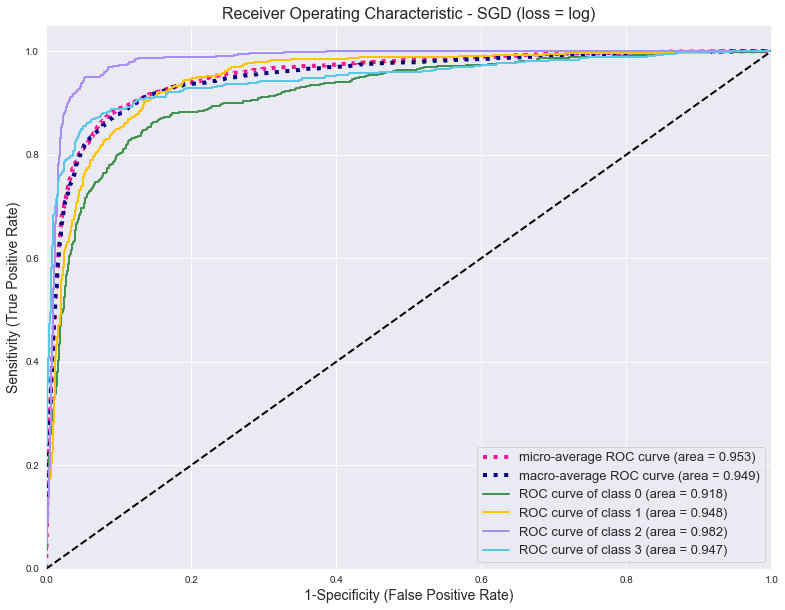

In [13]:
#When SGDClassifier is true

#Plot AUC - SGD

#Binarize the labels

if parameter["SGDClassifier"] == True:
    y_b = label_binarize(y, classes = [0, 1, 2, 3])
    n_classes = y_b.shape[1]

    #Shuffle and split training and test sets with stratified sampling and binarized labels
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                                y_b,
                                                                test_size = .3,
                                                                shuffle = True,
                                                                stratify = y,
                                                                random_state = 3)

    #Learn to predict each class against the other
    sgd_classifier = OneVsRestClassifier(sgd_best_model)

    y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    #Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    #Plot all ROC curves
    plt.figure(figsize=(13,10)) 
    sns.set_style('darkgrid')
    lw=2

    plt.plot(fpr['micro'], 
             tpr['micro'], 
             label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
             color='deeppink',
             linestyle=':', 
             linewidth=4)

    plt.plot(fpr['macro'], 
             tpr['macro'], 
             label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
             color='navy', 
             linestyle=':', 
             linewidth=4)

    colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], 
                 color=color, 
                 lw=lw, 
                 label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
    plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
    plt.legend(loc="lower right", fontsize = 13)
    plt.show()

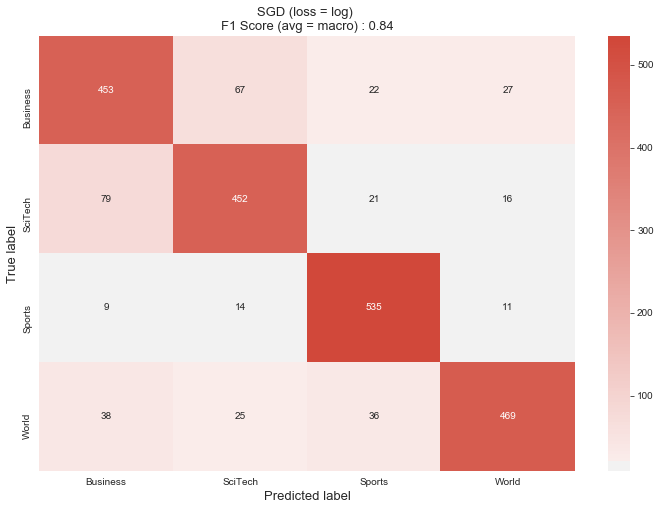

In [14]:
#When SGDClassifier is true

#Confusion Matrix - SGD
#Train test split with stratified sampling. Using non-binarized labels
if parameter["SGDClassifier"] == True:
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    #Fit the training data
    sgd_best_model.fit(X_train, y_train)

    #Predict the testing data
    y_pred = sgd_best_model.predict(X_test)

    #Get the confusion matrix and put it into a df
    cm = confusion_matrix(y_test, y_pred) 

    cm_df = pd.DataFrame(cm,
                         index = unique_categories, 
                         columns = unique_categories)

    #Plot the heatmap
    plt.figure(figsize=(12, 8))

    sns.heatmap(cm_df, 
                center=0, 
                cmap=sns.diverging_palette(220, 15, as_cmap=True), 
                annot=True, 
                fmt='g')

    plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
    plt.ylabel('True label', fontsize = 13)
    plt.xlabel('Predicted label', fontsize = 13)
    plt.show()

In [15]:
#When RandomForestClassifier parameter is true

#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

if parameter["RandomForestClassifier"] == True:
    #RF
    bootstrap = [True, False]
    max_depth = [10, 50, 100, None]
    max_features = ['auto', 'sqrt']
    min_samples_leaf = [1, 2, 4]
    min_samples_split = [2, 5, 10]
    n_estimators = [800, 1400, 2000]
    random_state = [3]

    clf = RandomForestClassifier()

    params = dict(bootstrap = bootstrap,
                  max_depth = max_depth,
                  max_features = max_features,
                  min_samples_leaf = min_samples_leaf,
                  n_estimators = n_estimators,
                  random_state=random_state)

    gridsearch = GridSearchCV(clf,
                              params, 
                              cv=5,
                              verbose=1, 
                              n_jobs=-1)

    rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 160.4min finished


In [16]:
#When RandomForestClassifier is true

#Define the best models with the selected params from the grdsearch
#Gridsearch was done on a virtual machine outisde of this notebook
#Normally you can just say 'best_model = gridsearch.best_params_' 
#to use the best parameters from the gridsearch

if parameter["RandomForestClassifier"] == True:
    rf_best_model = RandomForestClassifier(bootstrap = False,
                                           max_depth = 50,
                                           max_features = 'auto',
                                           min_samples_leaf = 1,
                                           n_estimators = 1400,
                                           random_state=3)

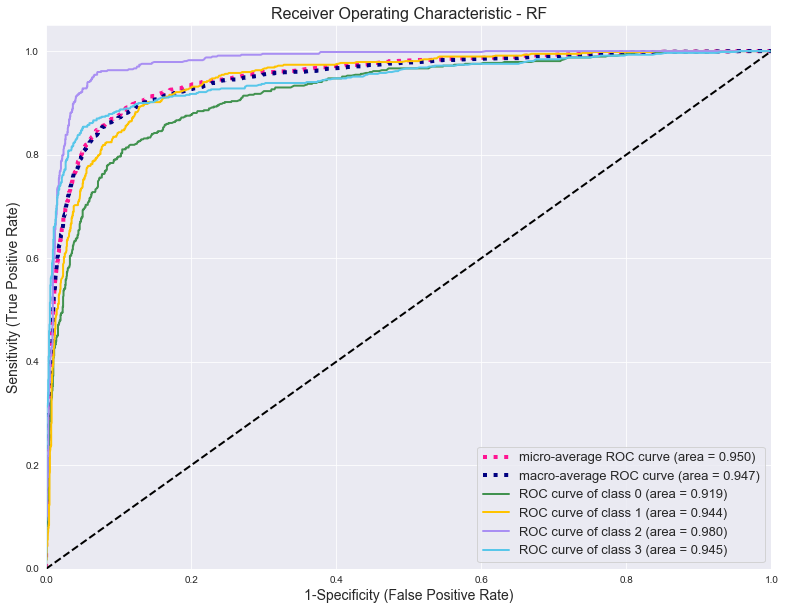

In [17]:
#When RandomForestClassifier parameter is true

#Plot AUC - RF
#Learn to predict each class against the other
    
if parameter["RandomForestClassifier"] == True:
    
    rf_classifier = OneVsRestClassifier(rf_best_model)

    y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    #Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    #Plot all ROC curves
    plt.figure(figsize=(13,10)) 
    sns.set_style('darkgrid')
    lw=2

    plt.plot(fpr['micro'], 
             tpr['micro'], 
             label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
             color='deeppink',
             linestyle=':', 
             linewidth=4)

    plt.plot(fpr['macro'], 
             tpr['macro'], 
             label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
             color='navy', 
             linestyle=':', 
             linewidth=4)

    colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], 
                 color=color, 
                 lw=lw, 
                 label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
    plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
    plt.legend(loc="lower right", fontsize = 13)
    plt.show()

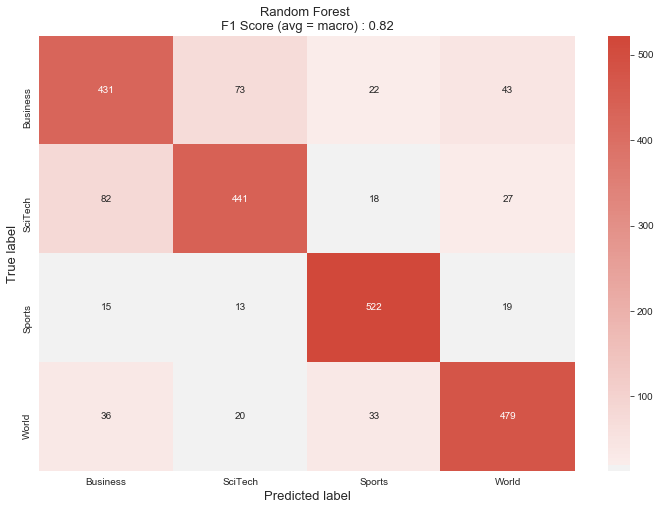

In [18]:
#When RandomForestClassifier is true

#Confusion Matrix - RF
#Fit the training data

if parameter["RandomForestClassifier"] == True:
    
    rf_best_model.fit(X_train, y_train)

    #Predict the testing data
    y_pred = rf_best_model.predict(X_test)

    #Get the confusion matrix and put it into a df
    cm = confusion_matrix(y_test, y_pred) 

    cm_df = pd.DataFrame(cm,
                         index = unique_categories, 
                         columns = unique_categories)

    #Plot the heatmap
    plt.figure(figsize=(12, 8))

    sns.heatmap(cm_df, 
                center=0, 
                cmap=sns.diverging_palette(220, 15, as_cmap=True), 
                annot=True, 
                fmt='g')

    plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
    plt.ylabel('True label', fontsize = 13)
    plt.xlabel('Predicted label', fontsize = 13)
    plt.show()

In [19]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['clean_text'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
if parameter["SGDClassifier"] == True:
    sgd_best_model.fit(X, y)
if parameter["RandomForestClassifier"] == True:
    rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels

if parameter["SGDClassifier"] == True:
    df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)

if parameter["RandomForestClassifier"] == True:
    df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {}
for i in range(0, len(unique_categories)):
    label_num_dict[unique_categories[i]] = i

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)


columns = ['content', 'label']
if parameter["SGDClassifier"] == True:
    columns.append('pred_sgd')
if parameter["RandomForestClassifier"] == True:
    columns.append('pred_rf')

columns.append('correct')

df_holdout = df_holdout[columns]

df_holdout

,content,label,pred_sgd,pred_rf,correct
0,Unions representing workers at Turner Newall...,Business,0,0,0
41,Reuters - Apparel retailers are hoping their\b...,Business,1,1,0
54,LONDON (Reuters) - The dollar dipped to a four...,Business,0,0,0
58,NEW YORK (Reuters) - U.S. Treasury debt prices...,Business,0,0,0
59,NEW YORK (Reuters) - The dollar extended gains...,Business,0,0,0
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,1,1,1
2,AP - A company founded by a chemistry research...,SciTech,1,1,1
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,2,2,1
4,AP - Southern California's smog-fighting agenc...,SciTech,3,3,1
5,The British Department for Education and Skill...,SciTech,1,1,1


In [22]:
#Using the original full unsampled dataset for predictions

conn = sqlite3.connect("train.sqlite3")

cur = conn.cursor()
cur.execute("SELECT [NOTE_TEXT], [GROUP] from Documents")

rows = cur.fetchall()

conn.close()

data = []
for row in rows:
    data.append({"note_text": row[0], "group": row[1]})

content, label = [], []
for each in data:
    content.append(each['note_text'])
    label.append(each['group'])
    if each['group'] not in unique_categories:
        unique_categories.append(each['group'])
        
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']

#Splitting the df into different categoreis
df_category_list = [ df.loc[df['label'] == e] for e in unique_categories ]

#Holding out 5 articles from each class for prediction at the end
df_category_holdout_list = [ e.iloc[:5] for e in df_category_list]

df_category_list = [ e.iloc[5:] for e in df_category_list]


#Appending the dfs back together
df = pd.concat(df_category_list)
df_holdout = pd.concat(df_category_holdout_list)

df['clean_text'] = df['content'].apply(process_text_unigram) 

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

#Get the text of the 5 articles we held out from each of the categories in the beginning
df_holdout['clean_text'] = df_holdout['content'].apply(process_text_unigram) 
unseen = df_holdout['clean_text'].astype('str') 

#Creating the features (tf-idf weights) for the processed text
texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

#Dimenionality reduction. Only using the 100 best features
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
if parameter["SGDClassifier"] == True:
    sgd_best_model.fit(X, y)
if parameter["RandomForestClassifier"] == True:
    rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
if parameter["SGDClassifier"] == True:
    df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
if parameter["RandomForestClassifier"] == True:
    df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {}
for i in range(0, len(unique_categories)):
    label_num_dict[unique_categories[i]] = i

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)


columns = ['content', 'label']
if parameter["SGDClassifier"] == True:
    columns.append('pred_sgd')
if parameter["RandomForestClassifier"] == True:
    columns.append('pred_rf')

columns.append('correct')

df_holdout = df_holdout[columns]

df_holdout

,content,label,pred_sgd,pred_rf,correct
0,Abstract\n \n \n in\n ...,Elderly Group,1,1,4
1,Abstract\n \n \n\n \n \n ...,Elderly Group,2,0,4
2,Abstract\n \n \n\n \n \n ...,Elderly Group,1,1,4
3,Abstract\n \n \n\n \n \n ...,Elderly Group,1,1,4
4,Abstract\n \n \n\n \n \n ...,Elderly Group,1,2,4
29,Abstract\n \n \n\n \n \n ...,Children Group,0,0,5
30,Abstract\n \n \n\n \n \n ...,Children Group,0,0,5
31,Abstract\n \n \n\n \n \n ...,Children Group,0,0,5
32,Abstract\n \n \n\n \n \n ...,Children Group,0,0,5
33,Abstract\n \n \n\n \n \n ...,Children Group,0,0,5
